# Demo: To compute SHAP values in PySpark

Prerequisite:
- Model must be not be pyspark.ml model as it is not serializable.

In [2]:
spark

In [4]:
import pickle

import numpy as np
import pandas as pd
import shap
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.types import *

from toolkit_spark import get_explainer, compute_shap
from constants import FEATURES, TARGET

## Load data in Spark dataframe

In [5]:
valid = spark.read.parquet("../eg_binary_class/inputs/valid1.gz.parquet")
valid.cache()
valid.count()

8344

## Load model

This example is a binary classification model.

In [6]:
model = pickle.load(open("../eg_binary_class/inputs/lgb_model.pkl", "rb"))

In [7]:
model_bc = spark.sparkContext.broadcast(model)

## Compute SHAP values

Using `rdd` and `mapPartitions`

In [8]:
def get_shap(rows):
    """
    Compute Shapley values in the shape of (prediction size x num_rows x (1 + len(features))).
    For each class and each row, the first value is the base value and the rest are shap values.
    """
    #################################################
    # Amend accordingly
    model = model_bc.value
    expl = get_explainer(model=model, model_type="tree")
    #################################################
    
    rows = np.squeeze(np.asarray(list(rows)))
    shap_values, base_value = compute_shap(expl, rows)

    results = []
    for i in range(rows.shape[0]):
        result = []
        for j in range(len(base_value)):
            result.append([base_value[j].item()] + shap_values[j][i].tolist())
        results.append(Row(*result))
    return results


In [16]:
# Compute Shapley values in the shape of (prediction size x num_rows x (1 + len(features))).
# For each class and each row, the first value is the base value and the rest are shap values.
    
x_df = valid.select(FEATURES).repartition(2)
shap_df = x_df.rdd.mapPartitions(get_shap).toDF(["shap_values"])

shap_df.cache()
shap_df.count()

8344

In [17]:
shap_df.show(1)

+--------------------+
|         shap_values|
+--------------------+
|[-2.9689216981484...|
+--------------------+
only showing top 1 row



## Checking computed SHAP values

In [19]:
# Take a data point and plot individual explainability
row = shap_df.take(1)[0][0]
row = np.asarray(row)

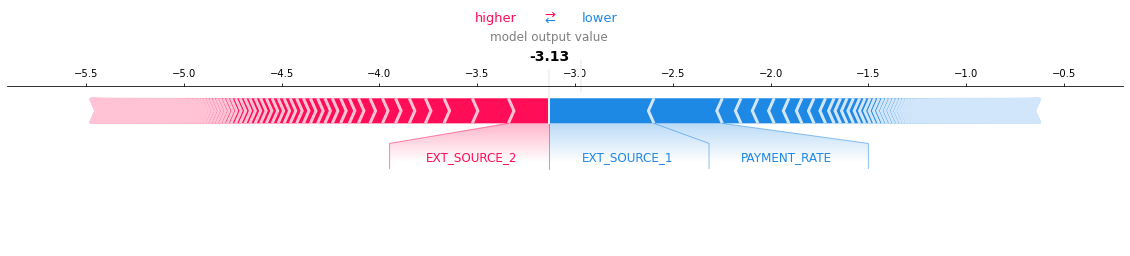

In [20]:
shap.force_plot(row[0], row[1:], FEATURES, matplotlib=True)